<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Logo-gustave-roussy.jpg/1200px-Logo-gustave-roussy.jpg" alt="Logo 1" width="250"/>
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/3/3f/Qube_Research_%26_Technologies_Logo.svg/1200px-Qube_Research_%26_Technologies_Logo.svg.png" alt="Logo 2" width="200" style="margin-left: 20px;"/>
</p>

# Data Challenge : Leukemia Risk Prediction


*GOAL OF THE CHALLENGE and WHY IT IS IMPORTANT:*

The goal of the challenge is to **predict disease risk for patients with blood cancer**, in the context of specific subtypes of adult myeloid leukemias.

The risk is measured through the **overall survival** of patients, i.e. the duration of survival from the diagnosis of the blood cancer to the time of death or last follow-up.

Estimating the prognosis of patients is critical for an optimal clinical management. 
For exemple, patients with low risk-disease will be offered supportive care to improve blood counts and quality of life, while patients with high-risk disease will be considered for hematopoietic stem cell transplantion.

The performance metric used in the challenge is the **IPCW-C-Index**.

*THE DATASETS*

The **training set is made of 3,323 patients**.

The **test set is made of 1,193 patients**.

For each patient, you have acces to CLINICAL data and MOLECULAR data.

The details of the data are as follows:

- OUTCOME:
  * OS_YEARS = Overall survival time in years
  * OS_STATUS = 1 (death) , 0 (alive at the last follow-up)

- CLINICAL DATA, with one line per patient:
  
  * ID = unique identifier per patient
  * CENTER = clinical center
  * BM_BLAST = Bone marrow blasts in % (blasts are abnormal blood cells)
  * WBC = White Blood Cell count in Giga/L 
  * ANC = Absolute Neutrophil count in Giga/L
  * MONOCYTES = Monocyte count in Giga/L
  * HB = Hemoglobin in g/dL
  * PLT = Platelets coutn in Giga/L
  * CYTOGENETICS = A description of the karyotype observed in the blood cells of the patients, measured by a cytogeneticist. Cytogenetics is the science of chromosomes. A karyotype is performed from the blood tumoral cells. The convention for notation is ISCN (https://en.wikipedia.org/wiki/International_System_for_Human_Cytogenomic_Nomenclature). Cytogenetic notation are: https://en.wikipedia.org/wiki/Cytogenetic_notation. Note that a karyotype can be normal or abnornal. The notation 46,XX denotes a normal karyotype in females (23 pairs of chromosomes including 2 chromosomes X) and 46,XY in males (23 pairs of chromosomes inclusing 1 chromosme X and 1 chromsome Y). A common abnormality in the blood cancerous cells might be for exemple a loss of chromosome 7 (monosomy 7, or -7), which is typically asssociated with higher risk disease

- GENE MOLECULAR DATA, with one line per patient per somatic mutation. Mutations are detected from the sequencing of the blood tumoral cells. 
We call somatic (= acquired) mutations the mutations that are found in the tumoral cells but not in other cells of the body.

  * ID = unique identifier per patient
  * CHR START END = position of the mutation on the human genome
  * REF ALT = reference and alternate (=mutant) nucleotide
  * GENE = the affected gene
  * PROTEIN_CHANGE = the consequence of the mutation on the protei that is expressed by a given gene
  * EFFECT = a broad categorization of the mutation consequences on a given gene.
  * VAF = Variant Allele Fraction = it represents the **proportion** of cells with the deleterious mutations. 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# Clinical Data
df = pd.read_csv("./clinical_train.csv")
df_eval = pd.read_csv("./clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("./molecular_train.csv")
maf_eval = pd.read_csv("./molecular_test.csv")

target_df = pd.read_csv("./target_train.csv")
target_df_test = pd.read_csv("./target_test.csv")

# Preview the data
df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


### Step 1: Data Preparation (clinical data only)

For survival analysis, we’ll format the dataset so that OS_YEARS represents the time variable and OS_STATUS represents the event indicator.

In [3]:
# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

# Check the data types to ensure 'OS_STATUS' is boolean and 'OS_YEARS' is numeric
print(target_df[['OS_STATUS', 'OS_YEARS']].dtypes)

# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

# Select features
features = ['BM_BLAST', 'HB', 'PLT']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df.loc[df['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

OS_STATUS       bool
OS_YEARS     float64
dtype: object


### Step 2: Splitting the Dataset
We’ll split the data into training and testing sets to evaluate the model’s performance.

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'PLT']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB', 'PLT']])
X_test[['BM_BLAST', 'HB', 'PLT']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'PLT']])

### Step 3: Training Standard Machine Learning Methods

In this step, we train a standard LightGBM model on survival data, but we do not account for censoring. Instead of treating the event status, we use only the observed survival times as the target variable. This approach disregards whether an individual’s event (e.g., death) was observed or censored, effectively treating the problem as a standard regression task. While this method provides a basic benchmark, it may be less accurate than survival-specific models (but still be explored!), as it does not leverage the information contained in censored observations.

In [6]:
# Import necessary libraries
import lightgbm as lgb
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# Define LightGBM parameters
lgbm_params = {
    'max_depth': 3,
    'learning_rate': 0.05,
    'verbose': -1
}

# Prepare the data for LightGBM
# Scale the target (OS_YEARS) to reduce skew, apply weights based on event status
X_train_lgb = X_train  # Features for training
y_train_transformed = y_train['OS_YEARS']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Make predictions on the training and testing sets
pred_train = -model.predict(X_train)
pred_test = -model.predict(X_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")


LightGBM Survival Model Concordance Index IPCW on train: 0.69
LightGBM Survival Model Concordance Index IPCW on test: 0.65


<Figure size 2000x1000 with 0 Axes>

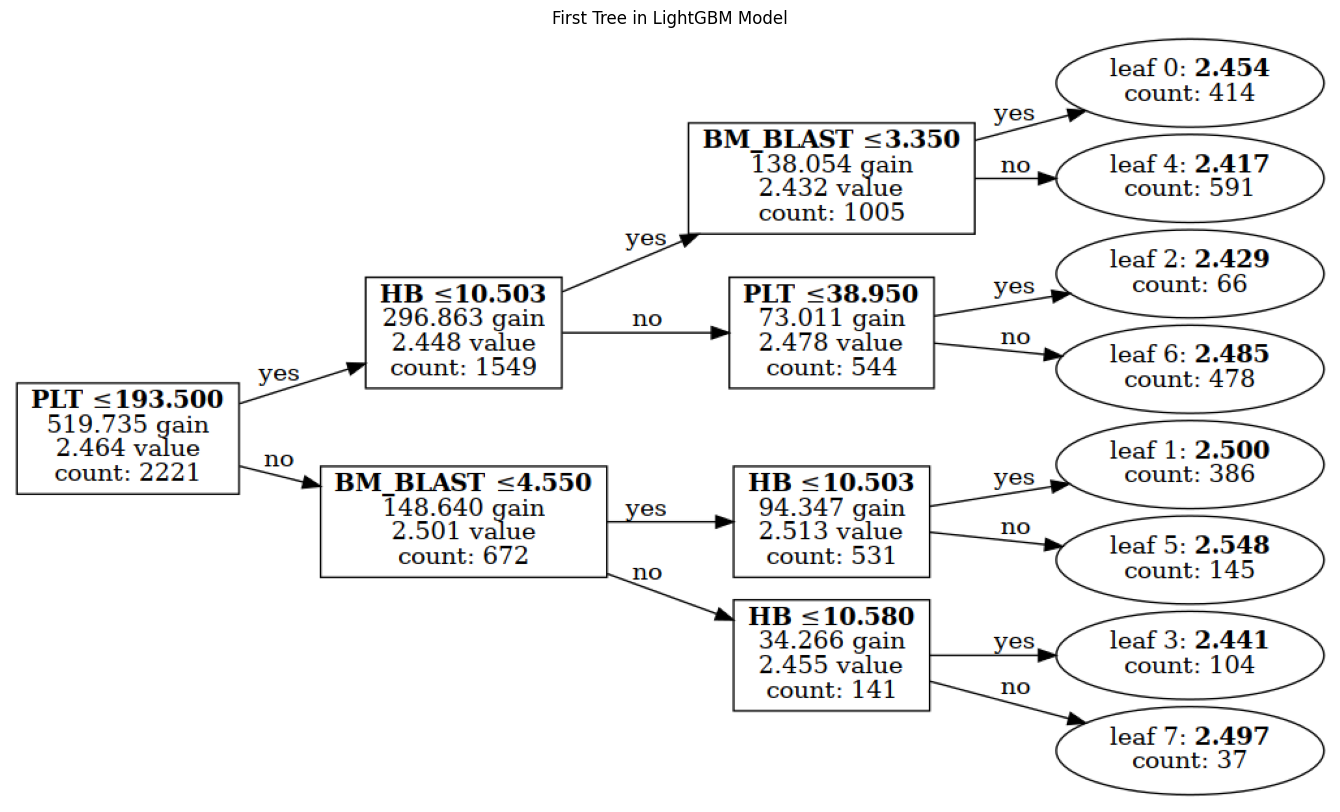

In [7]:
# Assuming the LightGBM model is defined as `model`
plt.figure(figsize=(20, 10))
lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.title("First Tree in LightGBM Model")
plt.show()

### Step 4: Cox Proportional Hazards Model

To account for censoring in survival analysis, we use a Cox Proportional Hazards (Cox PH) model, a widely used method that estimates the effect of covariates on survival times without assuming a specific baseline survival distribution. The Cox PH model is based on the hazard function, $h(t | X)$, which represents the instantaneous risk of an event (e.g., death) at time $t$ given covariates $X$. The model assumes that the hazard can be expressed as:

$$h(t | X) = h_0(t) \exp(\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p)$$


where $h_0(t)$ is the baseline hazard function, and $\beta$ values are coefficients for each covariate, representing the effect of $X$ on the hazard. Importantly, the proportional hazards assumption implies that the hazard ratios between individuals are constant over time. This approach effectively leverages both observed and censored survival times, making it a more suitable method for survival data compared to standard regression techniques that ignore censoring.


In [8]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.66
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.66


### Step 5: Naive Approach to Incorporate Mutations

In this step, we take a very naive approach to account for genetic mutations by simply counting the total number of somatic mutations per patient. Instead of analyzing specific mutations or their biological impact, we use this aggregate count as a basic feature to reflect the mutational burden for each individual. Although simplistic, this feature can serve as a general indicator of genetic variability across patients, which may influence survival outcomes. More sophisticated mutation analysis could be incorporated in future models to improve predictive power.


In [9]:
# Step: Extract the number of somatic mutations per patient
# Group by 'ID' and count the number of mutations (rows) per patient
tmp = maf_df.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_2 = df.merge(tmp, on='ID', how='left').fillna({'Nmut': 0})

In [10]:
# Select features
features = ['BM_BLAST', 'HB', 'PLT', 'Nmut']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df_2.loc[df_2['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'PLT', 'Nmut']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB', 'PLT', 'Nmut']])
X_test[['BM_BLAST', 'HB', 'PLT', 'Nmut']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'PLT', 'Nmut']])

In [13]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.68
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.68


### Inference on test set

In [14]:

tmp_eval = maf_eval.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_eval = df_eval.merge(tmp_eval, on='ID', how='left').fillna({'Nmut': 0})



In [15]:

df_eval[['BM_BLAST', 'HB', 'PLT', 'Nmut']] = imputer.transform(df_eval[['BM_BLAST', 'HB', 'PLT', 'Nmut']])

prediction_on_test_set = cox.predict(df_eval.loc[:, features])

In [16]:
prediction_on_test_set

array([ 0.86383926, -0.51383953, -1.73261271, ..., -1.69091907,
       -1.44228073, -1.5665999 ])

In [17]:
submission = pd.Series(prediction_on_test_set, index=df_eval['ID'], name='OS_YEARS')

In [18]:
submission

ID
KYW1       0.863839
KYW2      -0.513840
KYW3      -1.732613
KYW4       0.493820
KYW5      -1.125188
             ...   
KYW1189   -1.566600
KYW1190   -1.442281
KYW1191   -1.690919
KYW1192   -1.442281
KYW1193   -1.566600
Name: OS_YEARS, Length: 1193, dtype: float64

In [19]:

submission.to_csv('./benchmark_submission.csv')

In [20]:
submission

ID
KYW1       0.863839
KYW2      -0.513840
KYW3      -1.732613
KYW4       0.493820
KYW5      -1.125188
             ...   
KYW1189   -1.566600
KYW1190   -1.442281
KYW1191   -1.690919
KYW1192   -1.442281
KYW1193   -1.566600
Name: OS_YEARS, Length: 1193, dtype: float64

In [21]:

random_submission = pd.Series(np.random.uniform(0, 1, len(submission)),index =submission.index, name='OS_YEARS')


In [22]:
random_submission.to_csv('./random_submission.csv')

In [23]:
random_submission

ID
KYW1       0.344300
KYW2       0.556409
KYW3       0.194663
KYW4       0.564972
KYW5       0.025874
             ...   
KYW1189    0.338474
KYW1190    0.060352
KYW1191    0.840524
KYW1192    0.914133
KYW1193    0.936260
Name: OS_YEARS, Length: 1193, dtype: float64